Wilson's personal notebook

Metric: Transportation

Requires geopandas, pandas, pygeos

Neighborhood borders: https://data.wprdc.org/dataset/neighborhoods2
Transit stop locations: https://data.wprdc.org/dataset/port-authority-of-allegheny-county-transit-stops

In [4]:
# import libraries
import geopandas as gpd
import pandas as pd
from scipy import stats

/home/wbiggs/anaconda3/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [5]:
# read neighborhood polygons
neighborhoods = gpd.read_file('https://data.wprdc.org/dataset/e672f13d-71c4-4a66-8f38-710e75ed80a4/resource/4af8e160-57e9-4ebf-a501-76ca1b42fc99/download/pittsburghpaneighborhoods-.geojson')

# Reproject hoods to match CRS with meters as base
neighborhoods = neighborhoods.to_crs('+proj=cea +lat_0=40.440624 +lon_0=-79.995888 +units=m')

neighborhoods.head()

,objectid,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,page_number,plannerassign,created_user,created_date,last_edited_user,last_edited_date,temp,Shape__Area,Shape__Length,geometry
0,1293,201,42,003,980600,1,420039806001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,1.068796e+07,19600.573085,"POLYGON ((-3795.920 4118843.009, -3785.567 411..."
1,1294,10,42,003,261200,1,420032612001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,1.133208e+07,21174.473326,"POLYGON ((-1657.274 4122282.602, -1651.679 412..."
2,1295,11,42,003,260900,1,420032609001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,8.743618e+06,13811.917169,"POLYGON ((-821.954 4120841.104, -820.083 41208..."
3,1296,7,42,003,262000,1,420032620001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,1.754935e+07,18197.745741,"POLYGON ((-192.173 4120155.314, -191.926 41201..."
4,1297,8,42,003,261500,1,420032615001,Block Group 1,G5030,S,...,15,Stephanie Joy Everett,pgh.admin,2020-08-14T14:52:26.924999+00:00,pgh.admin,2020-08-14T14:52:26.924999+00:00,None,2.522420e+07,26390.549314,"POLYGON ((-2040.634 4120396.643, -2055.439 412..."


In [17]:
# create hood buffers
hoods_buffer = neighborhoods.assign(
  old_geom = neighborhoods['geometry'],
  geometry = lambda df: df['geometry'].map(lambda geom: geom.buffer(200))
).assign(
  geom_area = lambda df: df['geometry'].map(lambda geom: geom.area)
).assign(
  buffer_area = lambda df: df['buffer_geom'].map(lambda geom: geom.area)
)

In [7]:
# read bus stop points
stops = gpd.read_file('./wbiggs-data/paac_stops_1909/PAAC_Stops_1909.dbf')

# Reproject stops to match CRS with meters as base
stops = stops.to_crs('+proj=cea +lat_0=40.440624 +lon_0=-79.995888 +units=m')

#stops.head()

In [25]:
# try sjoin
stops_hoods_join = stops.sjoin(hoods_buffer)

hoods_buf_w_points = hoods_buffer.join(stops_hoods_join.groupby('index_right').size().rename('points'),how='left')

'46.0,41.0,42.0,69.0,116.0,33.0,77.0,74.0,70.0,59.0,54.0,35.0,31.0,58.0,75.0,77.0,59.0,56.0,16.0,32.0,11.0,84.0,134.0,76.0,135.0,72.0,70.0,48.0,86.0,47.0,30.0,177.0,59.0,75.0,46.0,148.0,38.0,85.0,86.0,87.0,61.0,125.0,81.0,59.0,130.0,103.0,61.0,110.0,52.0,93.0,128.0,61.0,67.0,101.0,10.0,43.0,67.0,37.0,56.0,25.0,88.0,80.0,82.0,98.0,157.0,25.0,27.0,37.0,9.0,13.0,72.0,9.0,23.0,28.0,23.0,33.0,78.0,28.0,56.0,93.0,52.0,69.0,37.0,40.0,67.0,32.0,8.0,26.0,nan,14.0'

In [26]:
# Count stops per neighborhood
hood_stop_count = []

for i, hood in neighborhoods.iterrows():
  count = 0

  if (i % 1000 == 0):
    print(i)

  for j, stop in stops.iterrows():
    if (hood.buffer_geom.contains(stop.geometry)):
      # it's in there!
      count += 1
  
  hood_stop_count.append({
    'name': hood.hood,
    'count': count,
    'area': hood.buffer_area,
    'count_per_sq_km': count / (hood.buffer_area / 1000000)
  })

hscdf = pd.DataFrame(hood_stop_count)

hscdf

0


'46,41,42,69,116,33,77,74,70,59,54,35,31,58,75,77,59,56,16,32,11,84,134,76,135,72,70,48,86,47,30,177,59,75,46,148,38,85,86,87,61,125,81,59,130,103,61,110,52,93,128,61,67,101,10,43,67,37,56,25,88,80,82,98,157,25,27,37,9,13,72,9,23,28,23,33,78,28,56,93,52,69,37,40,67,32,8,26,0,14'

array([[<AxesSubplot:title={'center':'stops_per_km2_scaled'}>]],
      dtype=object)

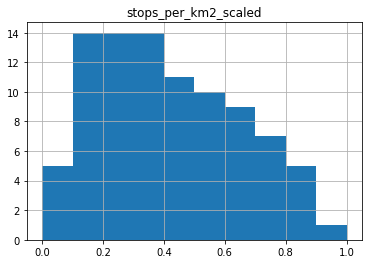

In [174]:
neighborhoods['stops_per_km2'] = hscdf['count_per_sq_km']
neighborhoods['stops_per_km2_scaled'] = (neighborhoods['stops_per_km2'] - neighborhoods['stops_per_km2'].min()) / (neighborhoods['stops_per_km2'].max() - neighborhoods['stops_per_km2'].min())

neighborhoods.hist(column='stops_per_km2_scaled')

<AxesSubplot:>

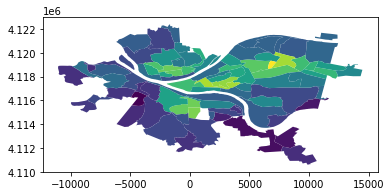

In [167]:
neighborhoods.plot(column='stops_per_km2_scaled')

In [2]:
import seaborn as sns

fit = stats.lognorm.fit(neighborhoods['stops_per_km2'])



NameError: name 'stats' is not defined